# Mean reversion 

Pairs trade is a mean-reverting strategy, betting that the prices will eventually revert to their historical trends.
🔧 Étape 1 – Ce que tu vas construire

Composant	Description

📥 Données	Téléchargement des prix de 2 actifs historiquement corrélés (ex : Coca-Cola et Pepsi, ou EUR/USD et GBP/USD)

📈 Spread	Calcul du spread entre les deux séries de prix

🔍 Détection de signal	Quand le spread s’écarte de la moyenne d’un certain seuil (Z-score), on parie sur un retour

🤖 Backtest	Simuler les entrées/sorties et calculer le PnL

⚙️ C++	Optimisation du calcul du Z-score, indicateurs et backtest

📊 Python	Gestion des données, visualisation, entraînement éventuel d’un modèle pour anticiper le retour à la moyenne

🔜 Prochaine étape :
On récupère des données de deux actifs corrélés.

Tu préfères :

Actions (ex : KO & PEP)

Forex (ex : EUR/USD & GBP/USD)

Crypto (ex : BTC & ETH)

Dis-moi et je t’indique comment récupérer les données et préparer le projet proprement.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMZN', 'META', 'JPM', 'XOM', 'UNH']

In [3]:
start_date = "2020-04-01"
end_date = "2025-03-31"
data = yf.download(tickers, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


I start here by selecting only the close price data in order to check if there is any correlation between two stock prices that I could use for the strategy.

In [4]:
correlated_data = data['Close']

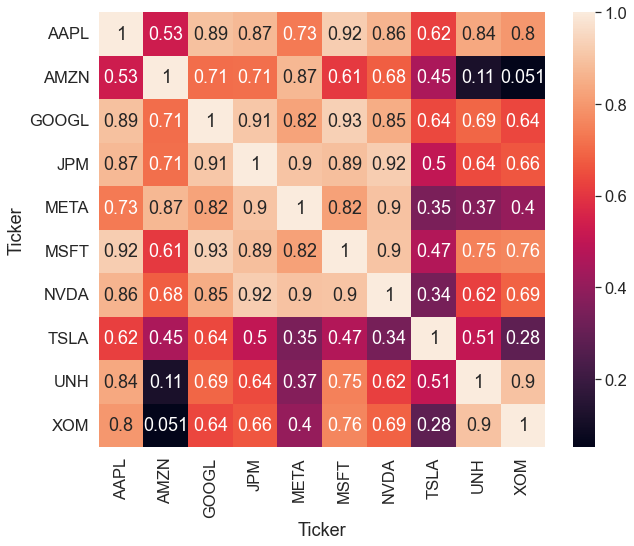

In [9]:
correlated_data.corr()
plt.figure(figsize= (10,8))
sns.set(font_scale=1.5)
sns.heatmap(correlated_data.corr(), annot=True)
plt.show()

We can observe that the maximum correlation ratio is between Microsoft and Google so we'll take this pair as a test. 

In [21]:
selected_data = data.loc[:, (slice(None), ['GOOGL', 'MSFT'])]

selected_data.head()

Price           Close                   High                    Low  \
Ticker          GOOGL        MSFT      GOOGL        MSFT      GOOGL   
Date                                                                  
2020-04-01  54.842796  145.596466  56.202298  150.994954  54.414345   
2020-04-02  55.585751  148.611588  55.871384  148.822168  54.396437   
2020-04-03  54.375034  147.242828  55.673328  150.640816  53.498230   
2020-04-06  58.878010  158.192932  59.254210  159.370258  55.982354   
2020-04-07  58.846657  156.489166  60.748567  162.720395  58.582421   

Price                        Open                Volume            
Ticker            MSFT      GOOGL        MSFT     GOOGL      MSFT  
Date                                                               
2020-04-01  144.361712  55.932587  146.448355  51970000  57969900  
2020-04-02  143.921417  54.738301  145.357185  56410000  49630700  
2020-04-03  145.673056  55.470300  148.458450  51374000  41243300  
2020-04-06  150.832225  56.380452  153.454900  63320000  67111700  
2020-04-07  156.269005  60.560961  162.327948  61620000  62769000

I'm going to use a simple linear regression to find the hedge called here Beta :

In [25]:
price_1 = selected_data['Close','GOOGL']

price_2 = selected_data['Close','MSFT']

In [32]:
# Reshape prix_B pour qu'il soit en 2D (n_samples, 1)
X = price_2.to_numpy().reshape(-1, 1)
y = price_1.to_numpy()

# Fit le modèle
model = LinearRegression(fit_intercept=False)  # pas d'ordonnée à l'origine
model.fit(X, y)

# Hedge ratio β
beta = model.coef_[0]
print(f"Hedge ratio β = {beta:.4f}")

Hedge ratio β = 0.4107


With the hedge Beta we can find the spread.

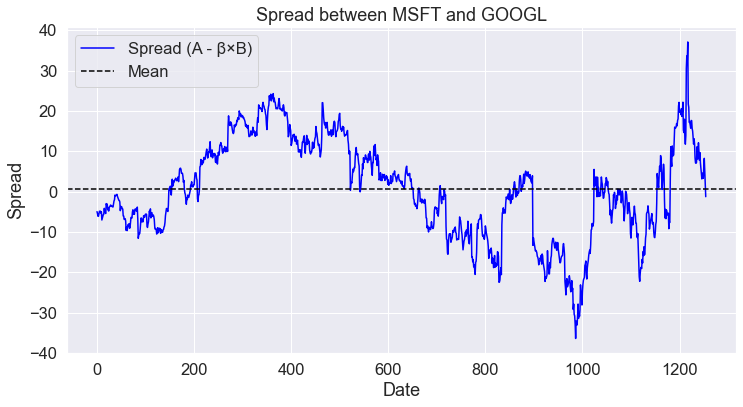

In [41]:
spread = y - beta * X.flatten()  # y = price_1, X = price_2.reshape(-1,1)

plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread (A - β×B)', color='blue')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.title('Spread between MSFT and GOOGL')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
std_spread = np.std(spread)
print(f"The std of the spread is : {std_spread:.4f}")

The std of the spread is : 12.1098


Now that we got the spread it's time for the backtesting. 

In [47]:
import numpy as np
import pandas as pd

# Parameters
initial_balance = 10000 
position_size = 1      
spread_mean = spread.mean()  
std_spread = np.std(spread)  
threshold =  std_spread /2

balance = initial_balance
positions = 0  # Position ouverte ou fermée (0 = pas de position, 1 = long actif 1/short actif 2, -1 = short actif 1/long actif 2)
trade_log = []

# Backtesting

